# Evacuation Planning Simulation for Suzu City

This notebook implements an evacuation planning simulation for Suzu city (珠洲市) in Ishikawa Prefecture, Japan.

## City Information:
- Population: 13,531 (as of March 2021)
- Households: 6,013
- Population density: 54.6 persons per km²
- Total area: 247.20 km²

## Algorithms Used:
1. **Maximum Flow Problem**: To determine optimal evacuation routes and capacities
2. **Time-Expanded Network**: To model evacuation over time with dynamic constraints
3. **Combinatorial Optimization**: To find the best evacuation plan

## Simulation Components:
- Road network from OpenStreetMap
- Population distribution
- Evacuation shelters/safe zones
- Time-dependent evacuation flow


Libraries imported successfully!
Available CPU cores: 20
Available memory: 9.3 GB
Execution time for load_graph: 2.72s | Memory change: +25.0MB
Execution time for load_graph: 2.72s | Memory change: +25.0MB


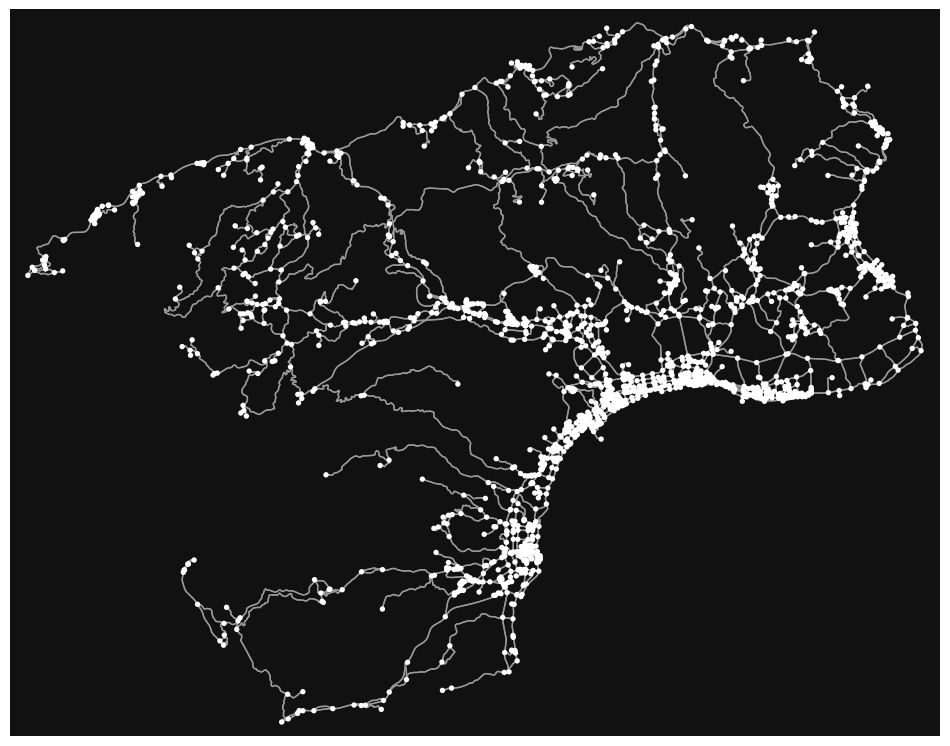

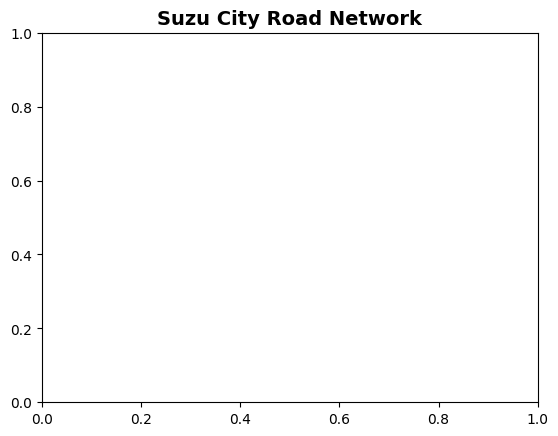

In [44]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Performance monitoring
import time
import psutil
import memory_profiler
from functools import wraps

# Animation and visualization imports
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from IPython.display import HTML, display, clear_output
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Parallel processing optimization
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Performance monitoring decorator
def monitor_performance(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        result = func(*args, **kwargs)
        
        end_time = time.time()
        end_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        print(f"Execution time for {func.__name__}: {end_time - start_time:.2f}s | Memory change: {end_memory - start_memory:+.1f}MB")
        return result
    return wrapper

print("Libraries imported successfully!")
print(f"Available CPU cores: {mp.cpu_count()}")
print(f"Available memory: {psutil.virtual_memory().available / 1024**3:.1f} GB")

place_name = "Suzu, Ishikawa, Japan"

@monitor_performance
def load_graph():
    return ox.graph_from_place(place_name, network_type='drive')

graph = load_graph()
fig, ax = ox.plot_graph(graph, figsize=(12, 10))
plt.title('Suzu City Road Network', fontsize=14, fontweight='bold')
plt.show()


In [45]:
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [46]:
edges.columns

Index(['osmid', 'highway', 'oneway', 'reversed', 'length', 'bridge',
       'geometry', 'name', 'ref', 'lanes', 'maxspeed', 'tunnel', 'width',
       'est_width', 'access'],
      dtype='object')

In [47]:
# Get nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph)

print(f"Network Statistics:")
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"\nNodes columns: {list(nodes.columns)}")
print(f"\nEdges columns: {list(edges.columns)}")

# Check the bounds of the network
bounds = nodes.total_bounds
print(f"\nNetwork bounds (lon_min, lat_min, lon_max, lat_max): {bounds}")
print(edges['length'])


Network Statistics:
Number of nodes: 1861
Number of edges: 5043

Nodes columns: ['y', 'x', 'street_count', 'junction', 'highway', 'geometry']

Edges columns: ['osmid', 'highway', 'oneway', 'reversed', 'length', 'bridge', 'geometry', 'name', 'ref', 'lanes', 'maxspeed', 'tunnel', 'width', 'est_width', 'access']

Network bounds (lon_min, lat_min, lon_max, lat_max): [137.0884597  37.3614715 137.3601281  37.5294151]
u            v            key
1281068967   1281085627   0      475.433891
             1281088757   0      308.617274
             1281093936   0      527.876788
1281068968   1281110312   0       63.387881
             1281147637   0      145.787930
                                    ...    
11554332531  11554332523  0       77.406863
             11491062922  0       24.558301
12193918084  1281126546   0       32.597996
             9572654173   0      181.919245
             1281092623   0       65.842164
Name: length, Length: 5043, dtype: float64


In [48]:
# Evacuation simulation parameters
class EvacuationParameters:
    def __init__(self):
        self.total_population = 13531   # Updated to 2021census
        self.total_households = 6013
        self.city_area_km2 = 247.20
        self.population_density = 54.6 # Updated to 2021 value
        
        # Evacuation parameters
        self.evacuation_time_limit = random.randint(120, 240)  # Evacuation time limit in minutes
        self.time_step = 5  # minutes
        self.walking_speed = 5  # km/h
        self.driving_speed = 30  # km/h
        self.evacuation_modes = ['walking', 'driving']
        
        # Capacity parameters
        self.road_capacity_per_meter = 0.5  # persons per meter of road width
        self.default_road_width = 4  # meters
        
params = EvacuationParameters()
print(f"Evacuation Parameters:")
print(f"Total Population: {params.total_population:,}")
print(f"Evacuation Time Limit: {params.evacuation_time_limit} minutes")
print(f"Time Steps: {params.time_step} minutes")


Evacuation Parameters:
Total Population: 13,531
Evacuation Time Limit: 201 minutes
Time Steps: 5 minutes


In [49]:
# Create population distribution across nodes
def distribute_population(nodes, total_population, method):
    """Distribute population across network nodes"""
    if method == 'random':
        # Randomly distribute population with some nodes having higher density
        weights = np.random.exponential(1, len(nodes))
        weights = weights / weights.sum()
        population = (weights * total_population).astype(int)
        
    elif method == 'central':
        # Higher population in central areas
        center_lon = nodes.geometry.x.mean()
        center_lat = nodes.geometry.y.mean()
        
        distances = np.sqrt((nodes.geometry.x - center_lon)**2 + 
                           (nodes.geometry.y - center_lat)**2)
        weights = 1 / (1 + distances / distances.max())
        weights = weights / weights.sum()
        population = (weights * total_population).astype(int)
    
    return population

# Distribute population
nodes['population'] = distribute_population(nodes, params.total_population, method='random')

# Ensure total population matches
total_assigned = nodes['population'].sum()
if total_assigned != params.total_population:
    diff = params.total_population - total_assigned
    # Add difference to the node with highest population
    max_pop_idx = nodes['population'].idxmax()
    nodes.loc[max_pop_idx, 'population'] += diff

print(f"Population Distribution:")
print(f"Total population assigned: {nodes['population'].sum():,}")
print(f"Max population at single node: {nodes['population'].max():,}")
print(f"Average population per node: {nodes['population'].mean():.1f}")
print(f"Nodes with population > 0: {(nodes['population'] > 0).sum()}")

Population Distribution:
Total population assigned: 13,531
Max population at single node: 979
Average population per node: 7.3
Nodes with population > 0: 1596


In [50]:
# Define real shelter locations (NAME, LONGITUDE, LATITUDE)
shelter_data = [
    ("Misaki Elementary School", 137.3386079 ,37.4865063),
    ("Misaki Junior High School", 137.3421125, 37.4735508),
    ("Misaki Kominkan", 137.3417233 ,37.4741329, ),
    ("Misaki Day service Center", 137.3411659,37.4682916 ),
    ("Former Kodomari Elementary School", 137.3579202 ,37.4512824),
    ("Bishouen", 137.3546414, 37.4550024),
    ("Former Hon Elementary School", 137.3191886, 37.4669704),
    ("Wakayama Elementary School", 137.2380186, 37.4564239),
    ("Wakayama Kominkan", 137.2414873, 37.4567271),
    ("Former Kamikuromaru Elementary School", 137.1675344, 37.4531086),
    ("Naminohana Day Service Center Satellite",  137.1717194, 37.4529168),
    ("Uedo Kominkan", 137.2514576, 37.4275655 ),
    ("Uedo Elementary School",  137.2500348, 37.42733367),
    ("Shoin Kominkan", 137.294170, 37.4441519 ),
    ("Shoin Elementary School", 137.2963972, 37.4455364 ),
    ("Former Iizuka Nursery school",  137.287401, 37.46005),
    ("Hioki Kominkan", 137.2816343, 37.5256146),
    ("Naminohana Day Service Center", 137.1737721, 37.5002642 ),
    ("Otani Sho Junior High School", 137.176221, 37.499813 ),
    ("Otani Kominkan", 137.17389061 ,37.5017345),
    ("Takojima Kominkan", 137.3162568, 37.4429716),
    ("Takojima Elementary School", 137.3135001 ,37.4428631),
    ("Iida Kominkan", 137.2634559, 37.4386061 ),
    ("Iida Elementary School", 137.2595845, 37.44139991),
    ("Horyu Kominkan", 137.239350, 37.4015919),
    ("Horyu Elementary and Junior High School",  137.2377243, 37.4029323),
    ("Daisan Chojuen", 137.239173 ,37.4050800),
    ("Former Horyu Elementary School", 137.236946, 37.3967473),
    ("Chojuen", 137.240152, 37.4113336),
    ("Midorigaoka Junior High School", 137.2822918, 37.4426085),
    ("Tada Elementary School", 137.2816905, 37.4439484),
    ("Tada Kominkan", 137.280125, 37.44379726),
    ("Daini Chojuen", 137.2534331, 37.3449641),
    ("Matsunami Elementary School", 137.2447520, 37.3497276),
    ("Matsunami Junior High School",  137.244516, 37.346722),
    ("Uchiura Gymnasium",  137.2518157, 37.3428780),
    ("Shiromaru Community Facility",  137.2636797, 37.32681930),
    ("Noto Worker Plaza",  137.2345965, 37.3128900),
    ("Ogi Junior High School",  137.2232442, 37.3042909),
    ("Ogi Area Exchange Center",  137.2239980, 37.3006649),
    ("Ogi Elementary School",  137.223728, 37.2992604),
    ("Hime Exchange Center",  137.2125856, 37.29643723),
    ("Takakura Kominkan",  137.20855914, 37.3022237),
    ("Former Mawaki Elementary School",  137.2050652, 37.306543),
    ("Elderly Rest House Tanagisou",  137.1609513, 37.3032503),
    ("Shirasagi Nursery school", 137.1528388, 37.3091604 ),
    ("Children Mirai Center",  137.1487435, 37.30880138),
    ("Ushitsu Elementary School", 137.1461702, 37.3066262),
    ("Noto Gymnasium", 137.1484292, 37.3032023 ),
    ("Hibari Nursery school (Provisional Building)",137.1483707, 37.3024730 ),
    ("Sakiyama Sanson Kaihatsu Center", 137.1486993, 37.3028518),
    ("Noto Junior High School",137.1440288, 37.3025005),
    ("Yanai Tennis Court", 137.13351926, 37.2949099),
    ("Sannami Kominkan", 137.1170012, 37.2891499),
    ("Noto Shichimi Health Welfare no Go Nagomi", 137.0935441, 37.2664550),
    ("Ukawa Elementary School",  137.0830517, 37.2572431),
    ("Ukawa Nursery school",  137.0838109, 37.25452872),
    ("Ukawa Kominkan", 137.0851153, 37.25335004 ),
    ("Omo Kominkan",  137.1139702, 37.3796981),
    ("Yanagida Elementary School", 137.0962415, 37.3665538),
    ("Yanagida Nursery school", 137.0873315, 37.3734405),
    ("Concert Noto", 137.1482760, 37.3101367),
    ("Jinno Kominkan", 137.0839002, 37.3159556),
    ("Mizuho Kominkan", 137.040578,37.2804149),
    ("Yanagida Junior High School", 137.0928745, 37.36575890),
    ("Yanagida Gymnasium", 137.0924464, 37.3687055),
    ("Yanagida Kominkan",137.0958325, 37.36939063),
    ("Kanmachi Kominkan", 137.1088014, 37.3505403),
    ("Iwaido Kominkan", 137.0396952, 37.3648832),
    ("Akiyoshi Kominkan", 137.2387345, 37.3330286),
    ("Ishikawa Prefectural Noto Industry Gijutsu Semmonko", 137.2065864, 37.33772706),
    ("Ishikawa Prefectural Noto High School", 137.1505371, 37.2991115),
    ("Kanmachi Kominkan Goroku Branch Office", 137.1362070, 37.3396300),
    ("Fudoji Kominkan", 137.2097332, 37.3378086),
    ("Matsunami Kominkan", 137.2449241, 37.3535669)
]


# Misaki Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Awazu Ro Department 10-1

# Misaki Junior High School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Uji Yo Department 114

# Misaki Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Uji Yo Department 114-13

# Misaki Day service Center ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Uji O Department 7

# Former Kodomari Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Kodomari 33-7

# Bishouen
#     Life / Living / Hospital ok
#     Ishikawa Suzu-shi Misakimachi

# Former Hon Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Hon 17-47

# Wakayama Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Wakayamamachi Furukura 11 Department 100-1

# Wakayama Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Wakayamamachi Furukura Tora Department 60-1

# Former Kamikuromaru Elementary School ok 
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Wakayamamachi Kamikuromaru 10 Department 34

# Naminohana Day Service Center Satellite ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Wakayamamachi Kamikuromaru 429-4

# Uedo Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Uedomachi Jisha 257-1

# Uedo Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Uedomachi Jisha 574-2

# Shoin Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Shoinmachi Shoin 22 Department 2-1

# Shoin Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Shoinmachi Kawashiri 1 Department 39

# Former Iizuka Nursery school ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Shoinmachi Iizuka Ha Department 57

# Hioki Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Oritomachi Chi Department 34

# Naminohana Day Service Center ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Otanimachi 111-4

# Otani Sho Junior High School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Otanimachi 178

# Otani Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Otanimachi 257-4



# Takojima Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Takojimamachi Yo Department 139

# Takojima Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Takojimamachi Wa Department 69

# Iida Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Iidamachi 10 Department 20-2

# Iida Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Iidamachi 19 Department 61

# Horyu Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Horyumachi Ukai U Department 46

# Horyu Elementary and Junior High School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Horyumachi Ukai Ushi Department 83

# Daisan Chojuen ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Horyumachi Ukai Ne 36-4

# Former Horyu Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Horyumachi Ushima 430

# Chojuen ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Horyumachi Kasugano 4117

# Midorigaoka Junior High School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Nonoemachi 6 no Department 1

# Tada Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Nonoemachi Ni Department 38-2

# Tada Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Nonoemachi Ho Department 80-1

# Daini Chojuen ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Nunoura No 10-3

# Matsunami Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Matsunami 15-80

# Matsunami Junior High School ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Matsunami 16-26

# Uchiura Gymnasium ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Nunoura Tsubuse 20-1

# Shiromaru Community Facility ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Shiromaru 2-17

# Noto Worker Plaza ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ossaka 11-51

# Ogi Junior High School ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ogi 1-1-1

# Ogi Area Exchange Center ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ogi 15-30-1



# Ogi Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ogi 4-16

# Hime Exchange Center ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Hime 10-250

# Takakura Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Hime 12-36

# Former Mawaki Elementary School  ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Mawaki 33-25

# Elderly Rest House Tanagisou ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu U10-1

# Shirasagi Nursery school ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu Futa 22

# Children Mirai Center ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu Ta 46-1

# Ushitsu Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu Mu 1

# Noto Gymnasium ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Sakiyama 1-1

# Hibari Nursery school (Provisional Building) ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Sakiyama 4-1

# Sakiyama Sanson Kaihatsu Center ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Sakiyama 1-1

# Noto Junior High School ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Fujinami 14-35

# Yanai Tennis Court ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Fujinami 23-1

# Sannami Kominkan ok
#     Life / Living / Hospital 
#     Ishikawa Hosu-gun Notocho Hanami 3-113

# Noto Shichimi Health Welfare no Go Nagomi ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Shichimi Tsu 100

# Ukawa Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ukawa 25-28

# Ukawa Nursery school ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ukawa 20-24

# Ukawa Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ukawa 18-128

# Omo Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho

# Yanagida Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Rei Department 2-1



# Yanagida Nursery school ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ro Department 245-1

# Concert Noto ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu To 29-2

# Jinno Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Tsurumachi 11-13-1

# Mizuho Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Mizuho 10-166

# Yanagida Junior High School ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Rei Department 3

# Yanagida Gymnasium ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Yanagida Ume Department 55

# Yanagida Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Yanagida Nibu 54

# Kanmachi Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Kanmachi 8-505

# Iwaido Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Kurokawa 26-11

# Akiyoshi Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Akiyoshi 757-banchi

# Ishikawa Prefectural Noto Industry Gijutsu Semmonko ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Matsunami 3-60-3

# Ishikawa Prefectural Noto High School ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu Ma 106-banchi 7

# Kanmachi Kominkan Goroku Branch Office ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Goroku 2865-banchi

# Fudoji Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Fudoji 8200-banchi 1

# Matsunami Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Matsunami 1375-banchi 1



# Identify evacuation shelters/safe zones based on predefined coordinates
def identify_evacuation_shelters_from_coords(nodes, predefined_shelters):
    """Identify evacuation shelters by finding the nearest available network node to predefined coordinates."""
    shelter_node_ids = []
    assigned_nodes = set()  # Track already assigned nodes
    
    if not predefined_shelters:
        print("No predefined shelters provided.")
        return []

    print(f"Processing {len(predefined_shelters)} shelters...")
    
    for i, (name, lon, lat) in enumerate(predefined_shelters):
        # Calculate distances to all nodes
        distances = np.sqrt((nodes.geometry.x - lon)**2 + (nodes.geometry.y - lat)**2)
        
        # Sort nodes by distance to find the nearest available one
        sorted_nodes = distances.sort_values()
        
        assigned_node = None
        for node_id in sorted_nodes.index:
            if node_id not in assigned_nodes:
                # Found an unassigned node
                assigned_node = node_id
                break
        
        if assigned_node is not None:
            shelter_node_ids.append(assigned_node)
            assigned_nodes.add(assigned_node)
            # Store shelter name on the node
            nodes.loc[assigned_node, 'shelter_name'] = name
            
            # Calculate distance for reporting
            distance = distances.loc[assigned_node]
            print(f"  {i+1:2d}. '{name}' -> Node {assigned_node} (distance: {distance:.6f})")
        else:
            print(f"  WARNING: Could not find available node for '{name}'")
    
    print(f"Successfully assigned {len(shelter_node_ids)} shelters to unique nodes")
    return shelter_node_ids

# Identify shelters using the predefined list
# You will need to populate `shelter_data` with actual (name, lon, lat) tuples
shelter_nodes = identify_evacuation_shelters_from_coords(nodes, shelter_data)

nodes['is_shelter'] = False
if shelter_nodes:
    nodes.loc[shelter_nodes, 'is_shelter'] = True

print(f"Evacuation Shelters:")
print(f"Number of shelters: {len(shelter_nodes)}")
# If you stored names and want to print them:
# for node_id in shelter_nodes:
# print(f"  Node ID: {node_id}, Name: {nodes.loc[node_id].get('shelter_name', 'N/A')}")
print(f"Shelter node IDs: {shelter_nodes}")


# Add capacity to shelters
nodes['shelter_capacity'] = 0 
if shelter_nodes: # Only assign capacities if shelters were identified
    shelter_capacities = np.random.randint(50, 151, size=len(shelter_nodes))
    nodes.loc[shelter_nodes, 'shelter_capacity'] = shelter_capacities
    print(f"Total shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].sum():,}")
    print(f"Average shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].mean():.1f}")
    print(f"Min shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].min()}")
    print(f"Max shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].max()}")
else:
    print("No shelters identified, so no capacities assigned.")

print(f"\\nDetailed shelter information:")
if shelter_nodes:
    shelter_info = nodes.loc[shelter_nodes, ['population', 'is_shelter', 'shelter_capacity', 'shelter_name']].copy()
    shelter_info.index.name = 'Node ID'
    print(shelter_info.sort_values('shelter_capacity', ascending=False))
else:
    print("No shelter information to display.")

Processing 75 shelters...
   1. 'Misaki Elementary School' -> Node 3762984021 (distance: 0.001070)
   2. 'Misaki Junior High School' -> Node 11506868426 (distance: 0.001034)
   3. 'Misaki Kominkan' -> Node 1281075355 (distance: 0.000684)
   4. 'Misaki Day service Center' -> Node 1281148941 (distance: 0.000908)
   5. 'Former Kodomari Elementary School' -> Node 1281148891 (distance: 0.000632)
   6. 'Bishouen' -> Node 1281106683 (distance: 0.001176)
   7. 'Former Hon Elementary School' -> Node 11493782008 (distance: 0.001218)
   8. 'Wakayama Elementary School' -> Node 11486765638 (distance: 0.001257)
   9. 'Wakayama Kominkan' -> Node 1281091320 (distance: 0.000389)
  10. 'Former Kamikuromaru Elementary School' -> Node 11476114070 (distance: 0.000279)
  11. 'Naminohana Day Service Center Satellite' -> Node 1281088408 (distance: 0.003097)
  12. 'Uedo Kominkan' -> Node 1281091172 (distance: 0.000735)
  13. 'Uedo Elementary School' -> Node 1281076637 (distance: 0.000436)
  14. 'Shoin Kominkan

In [51]:
# Calculate edge capacities and travel times
def calculate_edge_properties(edges, params):
    """Calculate capacity and travel time for each edge"""
    # Convert to numeric values, handling string values
    width_series = pd.to_numeric(edges['width'], errors='coerce')
    est_width_series = pd.to_numeric(edges['est_width'], errors='coerce')
    edges['width_calc'] = width_series.fillna(est_width_series).fillna(params.default_road_width)
    
    # Calculate capacity based on road width and length
    edges['capacity'] = (edges['width_calc'] * edges['length'] * params.road_capacity_per_meter / 100).astype(int)
    edges['capacity'] = edges['capacity'].clip(lower=10)  # Ensure minimum capacity of 10   
    
    # Calculate travel times (in minutes)
    # Walking time
    edges['walk_time'] = (edges['length'] / 1000) / params.walking_speed * 60  # minutes
    
    # Driving time (use maxspeed if available)
    max_speeds = edges['maxspeed'].fillna(params.driving_speed)
    # Convert string speeds to numeric
    max_speeds = pd.to_numeric(max_speeds, errors='coerce').fillna(params.driving_speed)
    edges['drive_time'] = (edges['length'] / 1000) / max_speeds * 60  # minutes
    
    return edges

# Calculate edge properties
edges = calculate_edge_properties(edges, params)

print(f"Edge Properties:")
print(f"Capacity - Min: {edges['capacity'].min()}, Max: {edges['capacity'].max()}, Mean: {edges['capacity'].mean():.1f}")
print(f"Walk time - Min: {edges['walk_time'].min():.2f}, Max: {edges['walk_time'].max():.2f} minutes")
print(f"Drive time - Min: {edges['drive_time'].min():.2f}, Max: {edges['drive_time'].max():.2f} minutes")

Edge Properties:
Capacity - Min: 10, Max: 112, Mean: 11.2
Walk time - Min: 0.01, Max: 67.27 minutes
Drive time - Min: 0.00, Max: 11.21 minutes


In [52]:
# Add west exit point to the evacuation network
def add_west_exit(nodes, edges, graph):
    """Add a west exit point for evacuation"""
    # Find the westernmost area of the city
    west_lon = nodes.geometry.x.min()
    lon_range = nodes.geometry.x.max() - nodes.geometry.x.min()
    west_threshold = west_lon + (lon_range * 0.15)
    
    # Get nodes in the western area
    west_nodes = nodes[nodes.geometry.x <= west_threshold]
    
    # Select the westernmost node as the exit point
    west_exit_node = west_nodes.geometry.x.idxmin()
    
    # Mark this node as a west exit
    nodes.loc[west_exit_node, 'is_west_exit'] = True
    nodes.loc[west_exit_node, 'exit_capacity'] = 10000
    
    print(f"West exit created at node {west_exit_node}")
    print(f"Exit location: ({nodes.loc[west_exit_node, 'geometry'].x:.4f}, {nodes.loc[west_exit_node, 'geometry'].y:.4f})")
    
    return west_exit_node

# Initialize exit columns if they don't exist
if 'is_west_exit' not in nodes.columns:
    nodes['is_west_exit'] = False
if 'exit_capacity' not in nodes.columns:
    nodes['exit_capacity'] = 0

def add_south_exit(nodes, edges, graph):
    """Add a south exit point for evacuation, using latitude between 37.4 and 37.45 and longitude between 137.15 and 137.2"""

    south_nodes = nodes[(nodes.geometry.y >= 37.4) & (nodes.geometry.y <= 37.45) & (nodes.geometry.x >= 137.15) & (nodes.geometry.x <= 137.2)]
    
    if south_nodes.empty:
        raise ValueError("No nodes found in the latitude range 37.4 to 37.45")
    
    # Select the southernmost node within this range
    south_exit_node = south_nodes.geometry.y.idxmin()
    
    # Mark this node as a south exit
    nodes.loc[south_exit_node, 'is_south_exit'] = True
    nodes.loc[south_exit_node, 'exit_capacity'] = 10000
    
    print(f"South exit created at node {south_exit_node}")
    print(f"Exit location: ({nodes.loc[south_exit_node, 'geometry'].x:.4f}, {nodes.loc[south_exit_node, 'geometry'].y:.4f})")
    
    return south_exit_node

def add_west_south_exit(nodes, edges, graph):
    """Add a west-south exit point for evacuation in the southwestern area"""
    #
    west_lon = nodes.geometry.x.min()
    south_lat = nodes.geometry.y.min()
    
    lon_range = nodes.geometry.x.max() - nodes.geometry.x.min()
    lat_range = nodes.geometry.y.max() - nodes.geometry.y.min()
    
    west_threshold = west_lon + (lon_range * 0.15) 
    south_threshold = south_lat + (lat_range * 0.15) + 0.07
    print(f"West-South exit thresholds: West {west_threshold:.4f}, South {south_threshold:.4f}")
    
    # Get nodes in the southwestern area
    southwest_nodes = nodes[
        (nodes.geometry.x >= west_threshold) & 
        (nodes.geometry.y >= south_threshold)
    ]
    
    if len(southwest_nodes) == 0:
        # If no nodes in the strict southwestern area, expand the search
        west_threshold = west_lon + (lon_range * 0.15) 
        south_threshold = south_lat + (lat_range * 0.15) + 0.07
        southwest_nodes = nodes[
            (nodes.geometry.x >= west_threshold) & 
            (nodes.geometry.y >= south_threshold)
        ]
    print(f"Southwest nodes found: {len(southwest_nodes)}")
    # Select the node that is closest to the southwest corner
    if len(southwest_nodes) > 0:
        # Calculate distance to southwest corner
        distances = np.sqrt(
            (southwest_nodes.geometry.x - west_lon)**2 + (southwest_nodes.geometry.y - south_lat)**2
        )
        west_south_exit_node = distances.idxmin()
    else:
        # Fallback: select the westernmost node among the southernmost nodes
        south_nodes = nodes[nodes.geometry.y <= south_lat + (lat_range * 2)] 
        west_south_exit_node = south_nodes.geometry.x.idxmin()
    
    # Mark this node as a west-south exit
    nodes.loc[west_south_exit_node, 'is_west_south_exit'] = True
    nodes.loc[west_south_exit_node, 'exit_capacity'] = 10000 
    
    print(f"West-South exit created at node {west_south_exit_node}")
    print(f"Exit location: ({nodes.loc[west_south_exit_node, 'geometry'].x:.4f}, {nodes.loc[west_south_exit_node, 'geometry'].y:.4f})")
    
    return west_south_exit_node

# Initialize exit columns if they don't exist
if 'is_south_exit' not in nodes.columns:
    nodes['is_south_exit'] = False
if 'is_west_south_exit' not in nodes.columns:
    nodes['is_west_south_exit'] = False
if 'exit_capacity' not in nodes.columns:
    nodes['exit_capacity'] = 0

add_west_exit(nodes, edges, graph)
add_south_exit(nodes, edges, graph)
add_west_south_exit(nodes, edges, graph)


West exit created at node 1281123728
Exit location: (137.0885, 37.4693)
South exit created at node 1281108573
Exit location: (137.1791, 37.4212)
West-South exit thresholds: West 137.1292, South 37.4567
Southwest nodes found: 802
West-South exit created at node 1281090837
Exit location: (137.1333, 37.4636)


np.int64(1281090837)

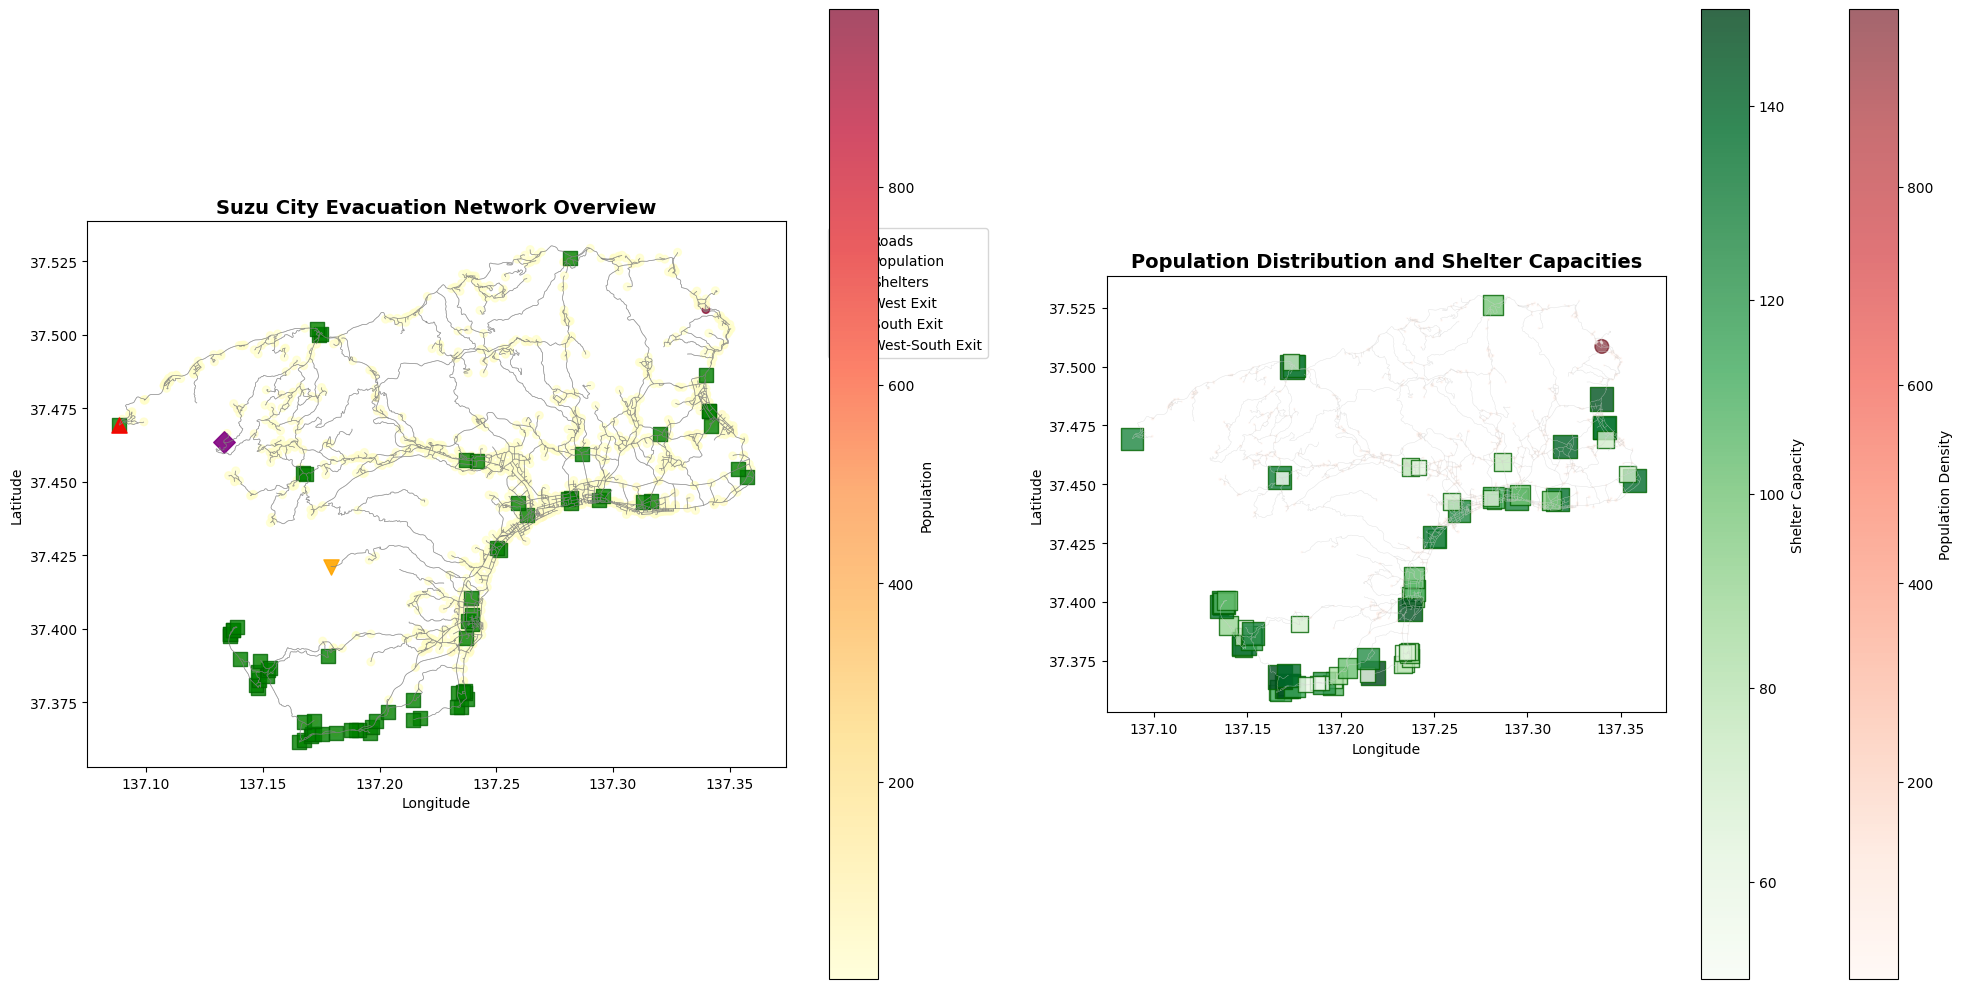


Network Summary:
Total nodes: 1,861
Total edges: 5,043
Population nodes: 1,596
Evacuation shelters: 75
Total population: 13,531
Total shelter capacity: 7,368
Coverage ratio: 54.45%


In [53]:
# Visualize the complete evacuation network
def visualize_evacuation_network(nodes, edges, shelter_nodes):
    """Create a comprehensive visualization of the evacuation network"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Left plot: Network overview
    edges.plot(ax=ax1, linewidth=0.5, alpha=0.6, color='gray', label='Roads')
    
    # Plot population nodes
    nodes_with_pop = nodes[nodes['population'] > 0]
    if not nodes_with_pop.empty:
        scatter = ax1.scatter(nodes_with_pop.geometry.x, nodes_with_pop.geometry.y, 
                             c=nodes_with_pop['population'], cmap='YlOrRd', 
                             s=30, alpha=0.7, label='Population')
        plt.colorbar(scatter, ax=ax1, label='Population')
    
    # Plot shelters
    if shelter_nodes:
        shelter_coords = nodes.loc[shelter_nodes]
        ax1.scatter(shelter_coords.geometry.x, shelter_coords.geometry.y, 
                   c='green', s=100, marker='s', alpha=0.8, label='Shelters', edgecolors='darkgreen')
    
    # Plot exits
    west_exits = nodes[nodes['is_west_exit'] == True]
    south_exits = nodes[nodes['is_south_exit'] == True]
    ws_exits = nodes[nodes['is_west_south_exit'] == True]
    
    if not west_exits.empty:
        ax1.scatter(west_exits.geometry.x, west_exits.geometry.y, 
                   c='red', s=120, marker='^', alpha=0.9, label='West Exit')
    if not south_exits.empty:
        ax1.scatter(south_exits.geometry.x, south_exits.geometry.y, 
                   c='orange', s=120, marker='v', alpha=0.9, label='South Exit')
    if not ws_exits.empty:
        ax1.scatter(ws_exits.geometry.x, ws_exits.geometry.y, 
                   c='purple', s=120, marker='D', alpha=0.9, label='West-South Exit')
    
    ax1.set_title('Suzu City Evacuation Network Overview', fontsize=14, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    
    # Right plot: Population density and shelter capacity
    edges.plot(ax=ax2, linewidth=0.3, alpha=0.4, color='lightgray')
    
    # Population density
    if not nodes_with_pop.empty:
        pop_scatter = ax2.scatter(nodes_with_pop.geometry.x, nodes_with_pop.geometry.y, 
                                 c=nodes_with_pop['population'], cmap='Reds', 
                                 s=nodes_with_pop['population']/10, alpha=0.6)
        plt.colorbar(pop_scatter, ax=ax2, label='Population Density')
    
    # Shelter capacity
    if shelter_nodes:
        shelter_coords = nodes.loc[shelter_nodes]
        shelter_caps = shelter_coords['shelter_capacity']
        capacity_scatter = ax2.scatter(shelter_coords.geometry.x, shelter_coords.geometry.y, 
                                      c=shelter_caps, cmap='Greens', 
                                      s=shelter_caps*2, marker='s', alpha=0.8, edgecolors='darkgreen')
        plt.colorbar(capacity_scatter, ax=ax2, label='Shelter Capacity')
    
    ax2.set_title('Population Distribution and Shelter Capacities', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nNetwork Summary:")
    print(f"Total nodes: {len(nodes):,}")
    print(f"Total edges: {len(edges):,}")
    print(f"Population nodes: {len(nodes_with_pop):,}")
    print(f"Evacuation shelters: {len(shelter_nodes)}")
    print(f"Total population: {nodes['population'].sum():,}")
    print(f"Total shelter capacity: {nodes['shelter_capacity'].sum():,}")
    print(f"Coverage ratio: {nodes['shelter_capacity'].sum() / nodes['population'].sum():.2%}")

# Create the visualization
visualize_evacuation_network(nodes, edges, shelter_nodes)

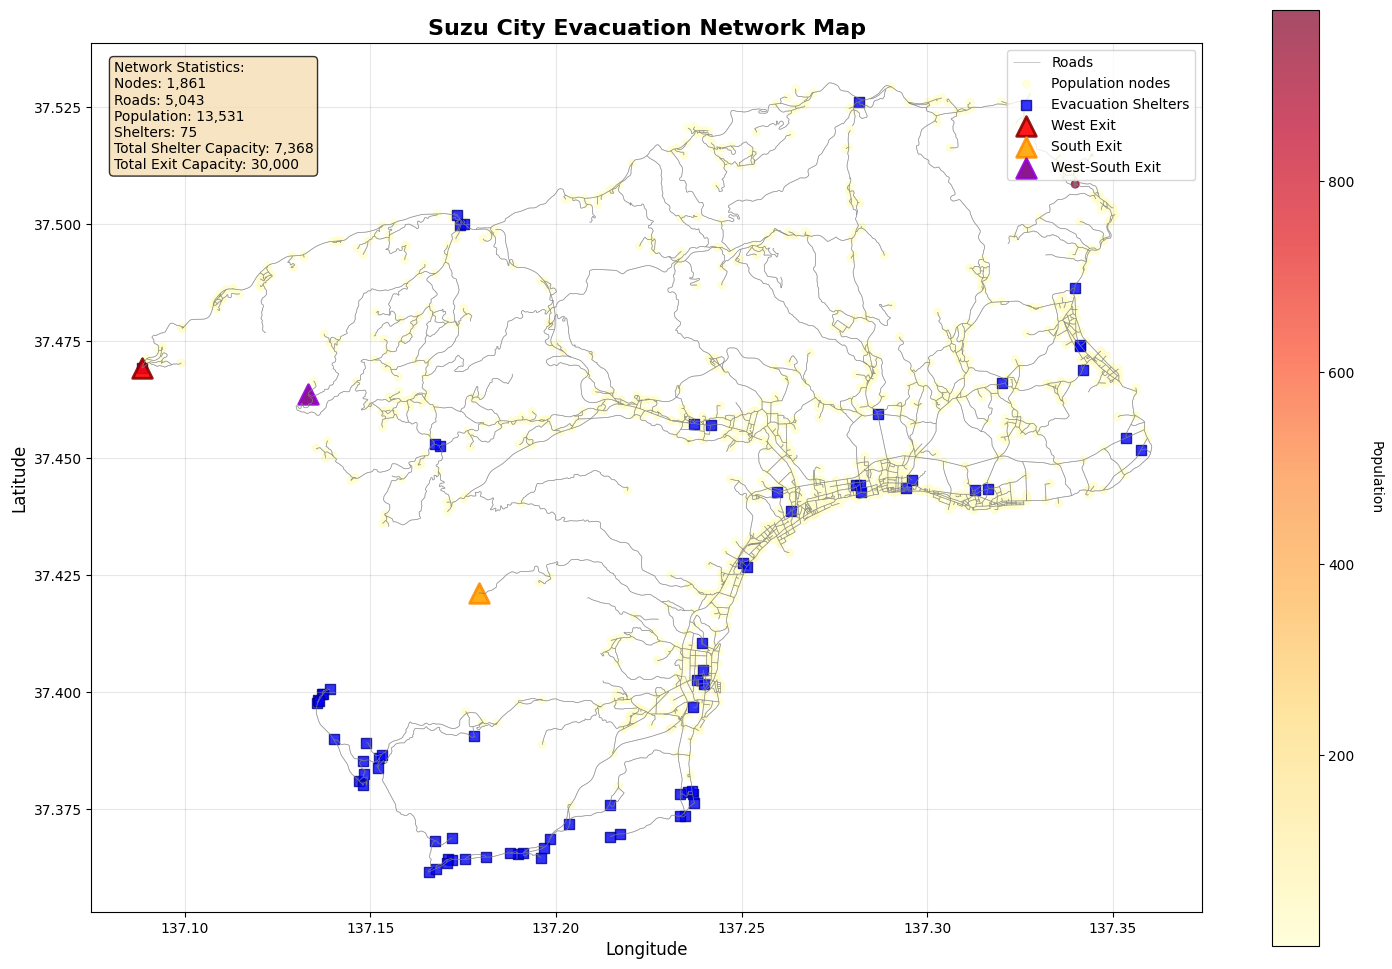


BASIC MAXIMUM FLOW ANALYSIS
Error in basic max flow: MultiGraph and MultiDiGraph not supported (yet).
Basic max flow analysis failed!


In [54]:
# Create a comprehensive map showing the evacuation network
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot the road network
edges.plot(ax=ax, linewidth=0.5, alpha=0.6, color='gray', label='Roads')

# Plot all nodes with population
nodes_with_pop = nodes[nodes['population'] > 0]
scatter = ax.scatter(nodes_with_pop.geometry.x, nodes_with_pop.geometry.y, 
                                        c=nodes_with_pop['population'], cmap='YlOrRd', 
                                        s=30, alpha=0.7, label='Population nodes')

# Plot evacuation shelters
shelter_nodes_data = nodes[nodes['is_shelter']]
ax.scatter(shelter_nodes_data.geometry.x, shelter_nodes_data.geometry.y, 
                  c='blue', s=50, marker='s', alpha=0.8, label='Evacuation Shelters', 
                  edgecolors='darkblue', linewidth=1)

# Plot west exit
west_exit_data = nodes[nodes['is_west_exit']]
ax.scatter(west_exit_data.geometry.x, west_exit_data.geometry.y, 
                  c='red', s=200, marker='^', alpha=0.9, label='West Exit', 
                  edgecolors='darkred', linewidth=2)

# Plot south exit
south_exit_data = nodes[nodes['is_south_exit']]
ax.scatter(south_exit_data.geometry.x, south_exit_data.geometry.y, 
                  c='orange', s=200, marker='^', alpha=0.9, label='South Exit', 
                  edgecolors='darkorange', linewidth=2)

# Plot west-south exit
west_south_exit_data = nodes[nodes['is_west_south_exit']]
ax.scatter(west_south_exit_data.geometry.x, west_south_exit_data.geometry.y, 
                  c='purple', s=200, marker='^', alpha=0.9, label='West-South Exit', 
                  edgecolors='darkviolet', linewidth=2)

# Add colorbar for population
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Population', rotation=270, labelpad=20)

# Add title and labels
ax.set_title('Suzu City Evacuation Network Map', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Add grid
ax.grid(True, alpha=0.3)

# Calculate correct exit capacities
total_exit_capacity = nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']]['exit_capacity'].sum()

# Add statistics text box
stats_text = f"""Network Statistics:
Nodes: {len(nodes):,}
Roads: {len(edges):,}
Population: {nodes['population'].sum():,}
Shelters: {len(shelter_nodes)}
Total Shelter Capacity: {nodes['shelter_capacity'].sum():,}
Total Exit Capacity: {total_exit_capacity:,}"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Basic Maximum Flow Analysis (without time expansion)
def basic_max_flow_analysis(graph, nodes, shelter_nodes):
    """Perform basic maximum flow analysis without time expansion"""
    print("\n" + "="*50)
    print("BASIC MAXIMUM FLOW ANALYSIS")
    print("="*50)
    
    # Create flow network
    flow_graph = graph.copy()
    
    # Add super source and sink
    flow_graph.add_node('super_source')
    flow_graph.add_node('super_sink')
    
    # Connect population sources
    total_population = 0
    for node_id in nodes.index:
        population = nodes.loc[node_id, 'population']
        if population > 0:
            flow_graph.add_edge('super_source', node_id, capacity=int(population))
            total_population += population
    
    # Connect shelters to sink
    for shelter in shelter_nodes:
        capacity = nodes.loc[shelter, 'shelter_capacity']
        flow_graph.add_edge(shelter, 'super_sink', capacity=int(capacity))
    
    # Connect exits to sink
    exit_nodes = nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']].index
    for exit_node in exit_nodes:
        capacity = nodes.loc[exit_node, 'exit_capacity']
        flow_graph.add_edge(exit_node, 'super_sink', capacity=int(capacity))
    
    # Calculate maximum flow
    try:
        flow_value, flow_dict = nx.maximum_flow(flow_graph, 'super_source', 'super_sink')
        
        print(f"Results:")
        print(f"Total population: {total_population:,}")
        print(f"Maximum evacuable: {flow_value:,}")
        print(f"Evacuation rate: {flow_value/total_population:.2%}")
        
        return {
            'flow_value': flow_value,
            'flow_dict': flow_dict,
            'total_population': total_population,
            'evacuation_rate': flow_value/total_population
        }
    except Exception as e:
        print(f"Error in basic max flow: {e}")
        return None

# Run basic analysis
basic_results = basic_max_flow_analysis(graph, nodes, shelter_nodes)

if basic_results:
    print(f"\nBasic max flow analysis completed successfully!")
else:
    print(f"Basic max flow analysis failed!")

In [55]:

G = nx.DiGraph()
G.add_nodes_from(nodes.index)
for idx, row in edges.iterrows():
    # idx is a tuple: (u, v, key)
    u, v = idx[0], idx[1]
    G.add_edge(u, v, 
               capacity=row['capacity'], 
               walk_time=row['walk_time'], 
               drive_time=row['drive_time'],
               length=row['length'])
    
# Add shelter and exit attributes to nodes
for node_id in nodes.index:
    G.nodes[node_id]['population'] = nodes.loc[node_id, 'population']
    G.nodes[node_id]['is_shelter'] = nodes.loc[node_id, 'is_shelter']
    G.nodes[node_id]['shelter_capacity'] = nodes.loc[node_id, 'shelter_capacity']
    G.nodes[node_id]['is_west_exit'] = nodes.loc[node_id, 'is_west_exit']
    G.nodes[node_id]['is_south_exit'] = nodes.loc[node_id, 'is_south_exit']
    G.nodes[node_id]['is_west_south_exit'] = nodes.loc[node_id, 'is_west_south_exit']
    G.nodes[node_id]['exit_capacity'] = nodes.loc[node_id, 'exit_capacity']


def calculate_max_flow(G, source, target):
    """Calculate maximum flow from source to target using the shortest augmenting path algorithm."""
    flow_value, flow_dict = nx.maximum_flow(G, source=source, target=target, flow_func=shortest_augmenting_path)
    return flow_value, flow_dict
def find_shelter_for_population(G, population):
    """Find the best shelter for a given population based on available capacity."""
    shelters = [n for n in G.nodes if G.nodes[n].get('is_shelter', False)]
    shelter_capacities = {s: G.nodes[s]['shelter_capacity'] for s in shelters}
    
    # Sort shelters by capacity
    sorted_shelters = sorted(shelter_capacities.items(), key=lambda x: x[1], reverse=True)
    
    total_capacity = 0
    selected_shelters = []
    
    for shelter, capacity in sorted_shelters:
        if total_capacity >= population:
            break
        selected_shelters.append(shelter)
        total_capacity += capacity
    
    return selected_shelters, total_capacity



In [56]:
from networkx.algorithms.flow import shortest_augmenting_path
from concurrent.futures import ProcessPoolExecutor, as_completed

# Calculate maximum flow from each node with population to all shelters and exits using parallel processing

# Collect all sink nodes (shelters and exits)
sink_nodes = set(shelter_nodes) | set(nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']].index)

# Only consider nodes with population > 0 and not a sink
source_nodes = [n for n in nodes_with_pop.index if n not in sink_nodes]

def max_flow_for_source(source):
    max_flow = 0
    for sink in sink_nodes:
        if source != sink:
            try:
                flow_value, _ = nx.maximum_flow(G, source, sink, flow_func=shortest_augmenting_path)
                max_flow = max(max_flow, flow_value)
            except nx.NetworkXError:
                continue
    return source, max_flow

max_flows = {}
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(max_flow_for_source, source): source for source in source_nodes}
    for future in as_completed(futures):
        source, max_flow = future.result()
        max_flows[source] = max_flow



In [57]:
top_flows = sorted(max_flows.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes with highest max flow to any shelter/exit:")
for node, flow in top_flows:
    print(f"Node {node}: Max flow = {flow}")

Top 10 nodes with highest max flow to any shelter/exit:
Node 1281080861: Max flow = 77
Node 1281071904: Max flow = 74
Node 1281074342: Max flow = 55
Node 1281070188: Max flow = 52
Node 1281077997: Max flow = 52
Node 1281080419: Max flow = 52
Node 1281135543: Max flow = 52
Node 1281137017: Max flow = 52
Node 1281142175: Max flow = 52
Node 1281072040: Max flow = 51


In [58]:
top_flows = sorted(max_flows.items(), key=lambda x: x[1], reverse=False)[:10]
print("Top 10 nodes with lowest min flow to any shelter/exit:")
for node, flow in top_flows:
    print(f"Node {node}: Max flow = {flow}")

Top 10 nodes with lowest min flow to any shelter/exit:
Node 1281069369: Max flow = 10
Node 1281069855: Max flow = 10
Node 1281069919: Max flow = 10
Node 1281070433: Max flow = 10
Node 1281070673: Max flow = 10
Node 1281070662: Max flow = 10
Node 1281071151: Max flow = 10
Node 1281071422: Max flow = 10
Node 1281072920: Max flow = 10
Node 1281072608: Max flow = 10


In [59]:
top_flows = sorted(max_flows.items(), key=lambda x: x[1], reverse=True)[:-1]
print("max flow to any shelter/exit:")
for node, flow in top_flows:
    print(f"Node {node}: Max flow = {flow}")

max flow to any shelter/exit:
Node 1281080861: Max flow = 77
Node 1281071904: Max flow = 74
Node 1281074342: Max flow = 55
Node 1281070188: Max flow = 52
Node 1281077997: Max flow = 52
Node 1281080419: Max flow = 52
Node 1281135543: Max flow = 52
Node 1281137017: Max flow = 52
Node 1281142175: Max flow = 52
Node 1281072040: Max flow = 51
Node 1281086027: Max flow = 51
Node 1281147953: Max flow = 51
Node 1281075126: Max flow = 50
Node 1281133374: Max flow = 50
Node 1281146035: Max flow = 50
Node 1281069274: Max flow = 48
Node 1281069706: Max flow = 45
Node 1281075287: Max flow = 45
Node 1281088524: Max flow = 45
Node 1281130971: Max flow = 45
Node 1281136636: Max flow = 45
Node 5938306199: Max flow = 45
Node 1281084744: Max flow = 44
Node 1281128036: Max flow = 44
Node 1281147102: Max flow = 44
Node 1281087570: Max flow = 43
Node 1281118986: Max flow = 42
Node 1281134163: Max flow = 42
Node 1281070629: Max flow = 41
Node 1281111405: Max flow = 41
Node 1281143950: Max flow = 41
Node 1281

In [68]:
# Time-Expanded Network Implementation for Suzu City Evacuation
class TimeExpandedEvacuation:
    def __init__(self, graph, nodes, edges, shelter_nodes, params):
        self.original_graph = graph
        self.nodes = nodes
        self.edges = edges
        self.shelter_nodes = shelter_nodes
        self.params = params
        
        # Get exit nodes from the current project
        self.exit_nodes = list(nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']].index)
        
        # Reduce time steps for faster computation
        self.time_horizons = list(range(0, min(300, params.evacuation_time_limit + 1), params.time_step))
        
        # Convert to simple graph for easier processing
        self.simple_graph = self._convert_to_simple_graph()
        print(f"Simple graph created with {len(self.simple_graph.nodes())} nodes and {len(self.simple_graph.edges())} edges")
        
        # Create time-expanded graph
        self.time_expanded_graph = self._create_time_expanded_graph()
        print(f"Time-expanded graph created with {len(self.time_expanded_graph.nodes())} nodes and {len(self.time_expanded_graph.edges())} edges")
    
    def _convert_to_simple_graph(self):
        """Convert MultiDiGraph to simple DiGraph for Suzu City network"""
        simple_graph = nx.DiGraph()
        
        # Add all nodes with their attributes
        for node_id in self.original_graph.nodes():
            node_attrs = self.original_graph.nodes[node_id].copy()
            simple_graph.add_node(node_id, **node_attrs)
        
        # Combine parallel edges by selecting the best capacity/time combination
        edge_data = {}
        
        # Check if the graph is a MultiDiGraph or simple DiGraph
        if isinstance(self.original_graph, nx.MultiDiGraph):
            # Handle MultiDiGraph case
            for u, v, key in self.original_graph.edges(keys=True):
                edge_key = (u, v)
                
                # Get edge properties from the original graph
                edge_attrs = self.original_graph[u][v][key].copy()
                
                if edge_key not in edge_data:
                    # Use the first edge found
                    edge_data[edge_key] = {
                        'capacity': max(1, int(edge_attrs.get('capacity', 10))),
                        'walk_time': max(0.1, edge_attrs.get('walk_time', 10)),
                        'drive_time': max(0.1, edge_attrs.get('drive_time', 5)),
                        'length': edge_attrs.get('length', 100)
                    }
                else:
                    # If multiple edges exist, take the one with higher capacity
                    existing_capacity = edge_data[edge_key]['capacity']
                    new_capacity = max(1, int(edge_attrs.get('capacity', 10)))
                    if new_capacity > existing_capacity:
                        edge_data[edge_key] = {
                            'capacity': new_capacity,
                            'walk_time': max(0.1, edge_attrs.get('walk_time', 10)),
                            'drive_time': max(0.1, edge_attrs.get('drive_time', 5)),
                            'length': edge_attrs.get('length', 100)
                        }
        else:
            # Handle simple DiGraph case
            for u, v in self.original_graph.edges():
                edge_key = (u, v)
                
                # Get edge properties from the original graph
                edge_attrs = self.original_graph[u][v].copy()
                
                edge_data[edge_key] = {
                    'capacity': max(1, int(edge_attrs.get('capacity', 10))),
                    'walk_time': max(0.1, edge_attrs.get('walk_time', 10)),
                    'drive_time': max(0.1, edge_attrs.get('drive_time', 5)),
                    'length': edge_attrs.get('length', 100)
                }
        
        # Add edges to simple graph
        for (u, v), data in edge_data.items():
            simple_graph.add_edge(u, v, **data)
        
        print(f"Converted to simple graph: {len(simple_graph.nodes())} nodes, {len(simple_graph.edges())} edges")
        return simple_graph
    
    def _create_time_expanded_graph(self):
        """Create time-expanded graph for evacuation simulation"""
        te_graph = nx.DiGraph()
        
        print(f"Creating time-expanded graph for {len(self.time_horizons)} time steps...")
        
        # Create nodes for each time step
        for t in self.time_horizons:
            for node in self.simple_graph.nodes():
                te_node = f"{node}_{t}"
                node_attrs = self.simple_graph.nodes[node].copy()
                node_attrs.update({
                    'original_node': node,
                    'time': t,
                    'is_shelter': node in self.shelter_nodes,
                    'is_exit': node in self.exit_nodes
                })
                te_graph.add_node(te_node, **node_attrs)
        
        # Add temporal edges (staying at same location)
        for node in self.simple_graph.nodes():
            node_capacity = self.nodes.loc[node, 'population'] if node in self.nodes.index else 100
            holding_capacity = max(100, int(node_capacity * 1.5))  # Allow some holding capacity
            
            for i in range(len(self.time_horizons) - 1):
                t1, t2 = self.time_horizons[i], self.time_horizons[i + 1]
                te_graph.add_edge(f"{node}_{t1}", f"{node}_{t2}", 
                                 edge_type='temporal', 
                                 capacity=holding_capacity,
                                 travel_time=0)
        
        # Add spatial edges (movement between locations)
        for u, v in self.simple_graph.edges():
            edge_data = self.simple_graph[u][v]
            walk_time = edge_data.get('walk_time', 10)
            capacity = edge_data.get('capacity', 10)
            
            # Round walk time to nearest time step
            time_steps_needed = max(1, int(np.ceil(walk_time / self.params.time_step)))
            actual_travel_time = time_steps_needed * self.params.time_step
            
            # Add edges if travel time allows
            for i, t in enumerate(self.time_horizons):
                arrival_step = i + time_steps_needed
                if arrival_step < len(self.time_horizons):
                    arrival_time = self.time_horizons[arrival_step]
                    
                    te_graph.add_edge(f"{u}_{t}", f"{v}_{arrival_time}",
                                     edge_type='spatial',
                                     capacity=capacity,
                                     travel_time=actual_travel_time,
                                     original_edge=(u, v))
        
        return te_graph
    
    def solve_time_expanded_flow(self, evacuation_scenario='normal'):
        """Solve evacuation using time-expanded network"""
        print(f"\nSolving time-expanded flow for scenario: {evacuation_scenario}")
        
        # Create super source and sink
        super_source = 'te_super_source'
        super_sink = 'te_super_sink'
        
        # Create a copy of the time-expanded graph
        temp_graph = self.time_expanded_graph.copy()
        temp_graph.add_node(super_source)
        temp_graph.add_node(super_sink)
        
        # Connect source to initial population nodes
        total_population_connected = 0
        for node_id in self.nodes.index:
            population = self.nodes.loc[node_id, 'population']
            if population > 0 and node_id not in self.shelter_nodes and node_id not in self.exit_nodes:
                initial_node = f"{node_id}_{self.time_horizons[0]}"
                if initial_node in temp_graph:
                    temp_graph.add_edge(super_source, initial_node, capacity=int(population))
                    total_population_connected += population
        
        print(f"Connected {total_population_connected:,} people to super source")
        
        # Connect shelter nodes at all times to super sink
        shelter_connections = 0
        for shelter in self.shelter_nodes:
            shelter_capacity = self.nodes.loc[shelter, 'shelter_capacity']
            for t in self.time_horizons:
                shelter_node = f"{shelter}_{t}"
                if shelter_node in temp_graph:
                    temp_graph.add_edge(shelter_node, super_sink, capacity=int(shelter_capacity))
                    shelter_connections += 1
        
        # Connect exit nodes at all times to super sink
        exit_connections = 0
        for exit_node in self.exit_nodes:
            exit_capacity = self.nodes.loc[exit_node, 'exit_capacity']
            for t in self.time_horizons:
                exit_te_node = f"{exit_node}_{t}"
                if exit_te_node in temp_graph:
                    temp_graph.add_edge(exit_te_node, super_sink, capacity=int(exit_capacity))
                    exit_connections += 1
        
        print(f"Connected {shelter_connections} shelter-time nodes and {exit_connections} exit-time nodes to super sink")
        
        # Solve maximum flow
        try:
            print("Computing maximum flow...")
            flow_value, flow_dict = nx.maximum_flow(temp_graph, super_source, super_sink)
            print(f"Maximum flow computed: {flow_value:,} people can be evacuated")
            return flow_value, flow_dict
        except nx.NetworkXError as e:
            print(f"Error in time-expanded flow: {e}")
            return 0, {}
    
    def analyze_evacuation_timeline(self):
        """Analyze evacuation progress over time"""
        print("\nAnalyzing evacuation timeline...")
        flow_value, flow_dict = self.solve_time_expanded_flow()
        
        if flow_value == 0:
            print("No evacuation flow found")
            return {}, 0
        
        # Calculate evacuated population at each time step
        timeline = {}
        shelter_timeline = {}
        exit_timeline = {}
        
        # Track cumulative evacuation
        for t in self.time_horizons:
            timeline[t] = 0
            shelter_timeline[t] = 0
            exit_timeline[t] = 0
            
            # Check flow to shelters
            for shelter in self.shelter_nodes:
                shelter_node = f"{shelter}_{t}"
                if shelter_node in flow_dict and 'te_super_sink' in flow_dict[shelter_node]:
                    flow_to_shelter = flow_dict[shelter_node]['te_super_sink']
                    shelter_timeline[t] += flow_to_shelter
                    timeline[t] += flow_to_shelter
            
            # Check flow to exits
            for exit_node in self.exit_nodes:
                exit_te_node = f"{exit_node}_{t}"
                if exit_te_node in flow_dict and 'te_super_sink' in flow_dict[exit_te_node]:
                    flow_to_exit = flow_dict[exit_te_node]['te_super_sink']
                    exit_timeline[t] += flow_to_exit
                    timeline[t] += flow_to_exit
        
        # Convert to cumulative evacuation
        cumulative_timeline = {}
        cumulative_shelter = {}
        cumulative_exit = {}
        
        total_evacuated = 0
        total_to_shelters = 0
        total_to_exits = 0
        
        for t in self.time_horizons:
            total_evacuated += timeline[t]
            total_to_shelters += shelter_timeline[t]
            total_to_exits += exit_timeline[t]
            
            cumulative_timeline[t] = total_evacuated
            cumulative_shelter[t] = total_to_shelters
            cumulative_exit[t] = total_to_exits
        
        results = {
            'timeline': cumulative_timeline,
            'shelter_timeline': cumulative_shelter,
            'exit_timeline': cumulative_exit,
            'total_flow': flow_value,
            'evacuation_rate': flow_value / self.nodes['population'].sum() if self.nodes['population'].sum() > 0 else 0
        }
        
        return results
    
    def get_evacuation_paths(self, flow_dict, source_node, max_paths=5):
        """Extract evacuation paths for a specific source node"""
        paths = []
        
        # Find initial node in time-expanded graph
        initial_node = f"{source_node}_{self.time_horizons[0]}"
        
        if initial_node not in flow_dict:
            return paths
        
        # Simple path extraction (this could be enhanced)
        current_nodes = [(initial_node, flow_dict.get('te_super_source', {}).get(initial_node, 0))]
        
        for current_node, flow in current_nodes:
            if flow > 0 and len(paths) < max_paths:
                node_id, time = current_node.rsplit('_', 1)
                paths.append({
                    'node': node_id,
                    'time': int(time),
                    'flow': flow,
                    'is_shelter': node_id in self.shelter_nodes,
                    'is_exit': node_id in self.exit_nodes
                })
        
        return paths

print("Time-Expanded Network Implementation loaded successfully!")

Time-Expanded Network Implementation loaded successfully!


In [69]:
# Create and run time-expanded network analysis  
print("Creating time-expanded network for Suzu City evacuation...")
print(f"Available shelters: {len(shelter_nodes)}")
print(f"Total population: {nodes['population'].sum():,}")
print(f"Time limit: {params.evacuation_time_limit} minutes")
print(f"Time step: {params.time_step} minutes")

# Create time-expanded solver
time_expanded_solver = TimeExpandedEvacuation(graph, nodes, edges, shelter_nodes, params)

# Run evacuation analysis
results = time_expanded_solver.analyze_evacuation_timeline()

if results:
    timeline = results['timeline']
    shelter_timeline = results['shelter_timeline']
    exit_timeline = results['exit_timeline']
    total_flow = results['total_flow']
    evacuation_rate = results['evacuation_rate']
    
    print(f"\nTime-Expanded Network Analysis Results:")
    print(f"Total population that can be evacuated: {total_flow:,}")
    print(f"Evacuation rate: {evacuation_rate:.2%}")
    print(f"Total population in city: {nodes['population'].sum():,}")
    
    print(f"\nEvacuation Timeline (every 30 minutes):")
    for i, (time, evacuated) in enumerate(timeline.items()):
        if time % 30 == 0 or time == max(timeline.keys()):  # Show every 30 minutes
            shelters_at_t = shelter_timeline[time]
            exits_at_t = exit_timeline[time]
            print(f"Time {time:3d} min: {evacuated:,} total ({shelters_at_t:,} to shelters, {exits_at_t:,} to exits)")
    
    # Calculate evacuation statistics
    final_time = max(timeline.keys())
    final_evacuated = timeline[final_time]
    
    print(f"\nFinal Evacuation Status:")
    print(f"Time horizon: {final_time} minutes")
    print(f"People evacuated: {final_evacuated:,} / {nodes['population'].sum():,}")
    print(f"Final evacuation rate: {final_evacuated / nodes['population'].sum():.2%}")
    
    # Breakdown by destination type
    final_to_shelters = shelter_timeline[final_time]
    final_to_exits = exit_timeline[final_time]
    
    if final_evacuated > 0:
        print(f"\nDestination Breakdown:")
        print(f"To shelters: {final_to_shelters:,} ({final_to_shelters/final_evacuated:.1%})")
        print(f"To exits: {final_to_exits:,} ({final_to_exits/final_evacuated:.1%})")
    
    # Store results for visualization
    te_results = {
        'timeline': timeline,
        'shelter_timeline': shelter_timeline,
        'exit_timeline': exit_timeline,
        'total_flow': total_flow,
        'evacuation_rate': evacuation_rate,
        'solver': time_expanded_solver
    }
    
    print(f"\nTime-expanded network analysis completed successfully!")
else:
    print("Failed to generate evacuation timeline")
    te_results = None

Creating time-expanded network for Suzu City evacuation...
Available shelters: 75
Total population: 13,531
Time limit: 201 minutes
Time step: 5 minutes
Converted to simple graph: 1861 nodes, 4950 edges
Simple graph created with 1861 nodes and 4950 edges
Creating time-expanded graph for 41 time steps...
Time-expanded graph created with 76301 nodes and 267490 edges

Analyzing evacuation timeline...

Solving time-expanded flow for scenario: normal
Time-expanded graph created with 76301 nodes and 267490 edges

Analyzing evacuation timeline...

Solving time-expanded flow for scenario: normal
Connected 13,025 people to super source
Connected 3075 shelter-time nodes and 123 exit-time nodes to super sink
Computing maximum flow...
Connected 13,025 people to super source
Connected 3075 shelter-time nodes and 123 exit-time nodes to super sink
Computing maximum flow...
Maximum flow computed: 12,035 people can be evacuated

Time-Expanded Network Analysis Results:
Total population that can be evacua

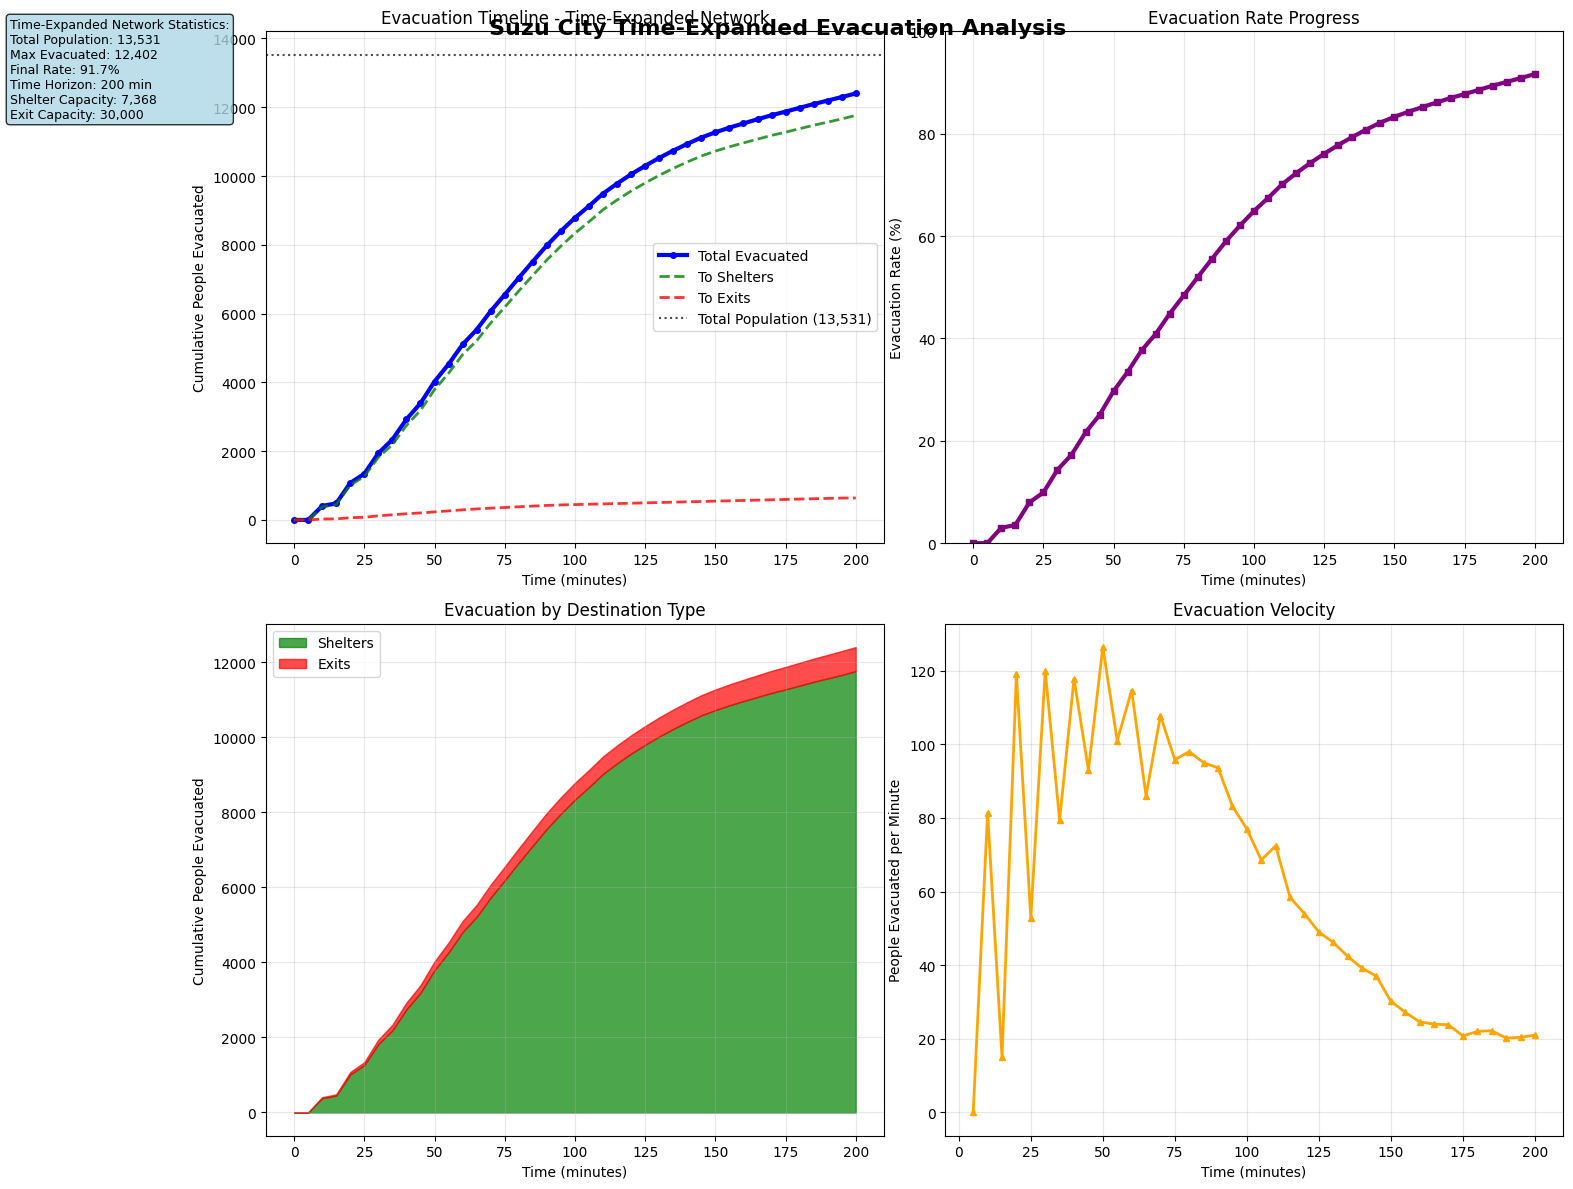


Detailed Analysis:
Peak evacuation velocity: 126.4 people/minute at 50 minutes
Time to evacuate 50% of population: 80 minutes
Time to evacuate 75% of population: 125 minutes
Time to evacuate 90% of population: 190 minutes

Network Efficiency:
Network utilization efficiency: 91.7%


In [70]:
# Visualize Time-Expanded Network Results
if te_results is not None:
    # Create evacuation timeline visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Total Evacuation Timeline
    times = list(te_results['timeline'].keys())
    total_evacuated = list(te_results['timeline'].values())
    shelter_evacuated = list(te_results['shelter_timeline'].values())
    exit_evacuated = list(te_results['exit_timeline'].values())
    
    ax1.plot(times, total_evacuated, 'b-', linewidth=3, label='Total Evacuated', marker='o', markersize=4)
    ax1.plot(times, shelter_evacuated, 'g--', linewidth=2, label='To Shelters', alpha=0.8)
    ax1.plot(times, exit_evacuated, 'r--', linewidth=2, label='To Exits', alpha=0.8)
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Cumulative People Evacuated')
    ax1.set_title('Evacuation Timeline - Time-Expanded Network')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add total population line
    total_pop = nodes['population'].sum()
    ax1.axhline(y=total_pop, color='black', linestyle=':', alpha=0.7, label=f'Total Population ({total_pop:,})')
    ax1.legend()
    
    # 2. Evacuation Rate Over Time
    evacuation_rates = [evacuated / total_pop * 100 for evacuated in total_evacuated]
    ax2.plot(times, evacuation_rates, 'purple', linewidth=3, marker='s', markersize=4)
    ax2.set_xlabel('Time (minutes)')
    ax2.set_ylabel('Evacuation Rate (%)')
    ax2.set_title('Evacuation Rate Progress')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    # 3. Destination Type Comparison (Stacked Area)
    ax3.fill_between(times, 0, shelter_evacuated, alpha=0.7, color='green', label='Shelters')
    ax3.fill_between(times, shelter_evacuated, total_evacuated, alpha=0.7, color='red', label='Exits')
    ax3.set_xlabel('Time (minutes)')
    ax3.set_ylabel('Cumulative People Evacuated')
    ax3.set_title('Evacuation by Destination Type')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Evacuation Velocity (people per time step)
    evacuation_velocity = []
    for i in range(1, len(total_evacuated)):
        velocity = (total_evacuated[i] - total_evacuated[i-1]) / params.time_step
        evacuation_velocity.append(velocity)
    
    velocity_times = times[1:]
    ax4.plot(velocity_times, evacuation_velocity, 'orange', linewidth=2, marker='^', markersize=4)
    ax4.set_xlabel('Time (minutes)')
    ax4.set_ylabel('People Evacuated per Minute')
    ax4.set_title('Evacuation Velocity')
    ax4.grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text = f"""Time-Expanded Network Statistics:
Total Population: {total_pop:,}
Max Evacuated: {max(total_evacuated):,}
Final Rate: {evacuation_rates[-1]:.1f}%
Time Horizon: {max(times)} min
Shelter Capacity: {nodes['shelter_capacity'].sum():,}
Exit Capacity: {nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']]['exit_capacity'].sum():,}"""
    
    fig.text(0.02, 0.98, stats_text, transform=fig.transFigure, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.18)  # Make room for stats box
    plt.suptitle('Suzu City Time-Expanded Evacuation Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    # Print additional analysis
    print(f"\nDetailed Analysis:")
    print(f"Peak evacuation velocity: {max(evacuation_velocity):.1f} people/minute at {velocity_times[evacuation_velocity.index(max(evacuation_velocity))]} minutes")
    
    # Calculate time to evacuate 50%, 75%, 90% of population
    for percentage in [50, 75, 90]:
        target = total_pop * percentage / 100
        for i, evacuated in enumerate(total_evacuated):
            if evacuated >= target:
                print(f"Time to evacuate {percentage}% of population: {times[i]} minutes")
                break
        else:
            print(f"Time to evacuate {percentage}% of population: >{max(times)} minutes (not achieved)")
    
    print(f"\nNetwork Efficiency:")
    max_theoretical_flow = min(nodes['shelter_capacity'].sum() + nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']]['exit_capacity'].sum(), total_pop)
    efficiency = (max(total_evacuated) / max_theoretical_flow) * 100 if max_theoretical_flow > 0 else 0
    print(f"Network utilization efficiency: {efficiency:.1f}%")
    
else:
    print("No time-expanded results to visualize")

In [71]:
# Compare Time-Expanded Network with Basic Max Flow
if te_results is not None:
    print("\n" + "="*60)
    print("COMPARISON: Time-Expanded vs Basic Max Flow Analysis")
    print("="*60)
    
    # Calculate basic max flow for comparison
    print("\nCalculating basic max flow for comparison...")
    
    # Create a simple max flow network
    flow_graph = G.copy()
    
    # Add super source and sink
    flow_graph.add_node('super_source')
    flow_graph.add_node('super_sink')
    
    # Connect population nodes to super source
    total_pop_connected = 0
    for node_id in nodes.index:
        population = nodes.loc[node_id, 'population']
        if population > 0 and node_id not in shelter_nodes and node_id not in te_results['solver'].exit_nodes:
            flow_graph.add_edge('super_source', node_id, capacity=int(population))
            total_pop_connected += population
    
    # Connect shelters and exits to super sink
    for shelter in shelter_nodes:
        shelter_capacity = nodes.loc[shelter, 'shelter_capacity']
        flow_graph.add_edge(shelter, 'super_sink', capacity=int(shelter_capacity))
    
    for exit_node in te_results['solver'].exit_nodes:
        exit_capacity = nodes.loc[exit_node, 'exit_capacity']
        flow_graph.add_edge(exit_node, 'super_sink', capacity=int(exit_capacity))
    
    # Calculate basic max flow
    try:
        basic_flow_value, basic_flow_dict = nx.maximum_flow(flow_graph, 'super_source', 'super_sink')
        basic_evacuation_rate = basic_flow_value / total_pop_connected if total_pop_connected > 0 else 0
    except:
        basic_flow_value = 0
        basic_evacuation_rate = 0
    
    # Comparison results
    te_flow_value = te_results['total_flow']
    te_evacuation_rate = te_results['evacuation_rate']
    
    print(f"\nRESULTS COMPARISON:")
    print(f"{'Metric':<30} {'Basic Max Flow':<20} {'Time-Expanded':<20} {'Difference':<15}")
    print("-" * 85)
    print(f"{'Total Flow':<30} {basic_flow_value:<20,} {te_flow_value:<20,} {te_flow_value - basic_flow_value:<15,}")
    print(f"{'Evacuation Rate':<30} {basic_evacuation_rate:<20.2%} {te_evacuation_rate:<20.2%} {te_evacuation_rate - basic_evacuation_rate:<15.2%}")
    
    # Time analysis
    if te_results['timeline']:
        final_time = max(te_results['timeline'].keys())
        print(f"{'Time Horizon':<30} {'Instantaneous':<20} {f'{final_time} minutes':<20} {'-':<15}")
    
    print(f"\nANALYSIS:")
    if te_flow_value > basic_flow_value:
        print(f"✓ Time-expanded network found {te_flow_value - basic_flow_value:,} more evacuable people")
        print(f"  This suggests the time dimension reveals additional evacuation capacity")
    elif te_flow_value < basic_flow_value:
        print(f"⚠ Time-expanded network found {basic_flow_value - te_flow_value:,} fewer evacuable people")
        print(f"  This suggests time constraints limit evacuation capacity")
    else:
        print(f"= Both methods found the same evacuation capacity")
        print(f"  Time constraints do not appear to be the limiting factor")
    
    # Bottleneck analysis
    total_capacity = nodes['shelter_capacity'].sum() + nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']]['exit_capacity'].sum()
    print(f"\nBOTTLENECK ANALYSIS:")
    print(f"Total population: {total_pop_connected:,}")
    print(f"Total shelter + exit capacity: {total_capacity:,}")
    print(f"Capacity utilization: {te_flow_value / total_capacity:.2%}")
    
    if te_flow_value < total_pop_connected:
        limiting_factor = min(total_capacity, total_pop_connected)
        if te_flow_value < limiting_factor * 0.8:
            print(f"⚠ Network connectivity appears to be the main bottleneck")
        else:
            print(f"✓ Network is efficiently utilizing available capacity")

else:
    print("Cannot perform comparison - no time-expanded results available")


COMPARISON: Time-Expanded vs Basic Max Flow Analysis

Calculating basic max flow for comparison...

RESULTS COMPARISON:
Metric                         Basic Max Flow       Time-Expanded        Difference     
-------------------------------------------------------------------------------------
Total Flow                     1,051                12,035               10,984         
Evacuation Rate                8.07%                88.94%               80.87%         
Time Horizon                   Instantaneous        200 minutes          -              

ANALYSIS:
✓ Time-expanded network found 10,984 more evacuable people
  This suggests the time dimension reveals additional evacuation capacity

BOTTLENECK ANALYSIS:
Total population: 13,025
Total shelter + exit capacity: 37,368
Capacity utilization: 32.21%
✓ Network is efficiently utilizing available capacity


In [72]:
# Performance Metrics and Network Analysis
if te_results is not None:
    print("\n" + "="*50)
    print("PERFORMANCE METRICS")
    print("="*50)
    
    solver = te_results['solver']
    
    print(f"\nNETWORK SIZE METRICS:")
    print(f"Original graph: {len(solver.original_graph.nodes()):,} nodes, {len(solver.original_graph.edges()):,} edges")
    print(f"Simple graph: {len(solver.simple_graph.nodes()):,} nodes, {len(solver.simple_graph.edges()):,} edges")
    print(f"Time-expanded graph: {len(solver.time_expanded_graph.nodes()):,} nodes, {len(solver.time_expanded_graph.edges()):,} edges")
    print(f"Time steps: {len(solver.time_horizons)}")
    print(f"Expansion factor: {len(solver.time_expanded_graph.nodes()) / len(solver.simple_graph.nodes()):.1f}x nodes")
    
    print(f"\nEVACUATION INFRASTRUCTURE:")
    print(f"Evacuation shelters: {len(solver.shelter_nodes)}")
    print(f"Exit points: {len(solver.exit_nodes)}")
    print(f"Total shelter capacity: {nodes['shelter_capacity'].sum():,}")
    print(f"Total exit capacity: {nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']]['exit_capacity'].sum():,}")
    
    # Calculate average path lengths in time-expanded network
    print(f"\nNETWORK CONNECTIVITY:")
    try:
        # Sample a few source-destination pairs to estimate connectivity
        sample_sources = [n for n in solver.simple_graph.nodes() if solver.simple_graph.nodes[n].get('population', 0) > 0][:10]
        sample_destinations = solver.shelter_nodes + solver.exit_nodes
        
        reachable_pairs = 0
        total_pairs = 0
        path_lengths = []
        
        for source in sample_sources[:5]:  # Limit to 5 sources for performance
            for dest in sample_destinations[:5]:  # Limit to 5 destinations
                if source != dest:
                    total_pairs += 1
                    try:
                        # Check in original simple graph
                        path = nx.shortest_path(solver.simple_graph, source, dest)
                        reachable_pairs += 1
                        path_lengths.append(len(path) - 1)  # Number of edges
                    except nx.NetworkXNoPath:
                        pass
        
        if total_pairs > 0:
            connectivity = reachable_pairs / total_pairs
            avg_path_length = np.mean(path_lengths) if path_lengths else 0
            print(f"Connectivity (sample): {connectivity:.2%} of source-destination pairs reachable")
            print(f"Average path length (sample): {avg_path_length:.1f} edges")
        
    except Exception as e:
        print(f"Could not calculate connectivity metrics: {e}")
    
    # Evacuation efficiency metrics
    timeline = te_results['timeline']
    if timeline:
        print(f"\nEVACUATION EFFICIENCY:")
        
        # Find time to reach various evacuation percentages
        total_pop = nodes['population'].sum()
        times = list(timeline.keys())
        evacuated_counts = list(timeline.values())
        
        milestones = [0.1, 0.25, 0.5, 0.75, 0.9]
        for milestone in milestones:
            target = total_pop * milestone
            time_to_milestone = None
            
            for i, count in enumerate(evacuated_counts):
                if count >= target:
                    time_to_milestone = times[i]
                    break
            
            if time_to_milestone is not None:
                print(f"Time to evacuate {milestone:.0%}: {time_to_milestone} minutes")
            else:
                print(f"Time to evacuate {milestone:.0%}: >>{max(times)} minutes (not achieved)")
        
        # Calculate evacuation rate (people per minute)
        if len(evacuated_counts) > 1:
            max_rate = 0
            for i in range(1, len(evacuated_counts)):
                rate = (evacuated_counts[i] - evacuated_counts[i-1]) / params.time_step
                max_rate = max(max_rate, rate)
            
            print(f"\nPeak evacuation rate: {max_rate:.1f} people/minute")
            avg_rate = evacuated_counts[-1] / times[-1] if times[-1] > 0 else 0
            print(f"Average evacuation rate: {avg_rate:.1f} people/minute")
    
    print(f"\nRECOMMENDATIONS:")
    
    # Provide recommendations based on results
    evacuation_rate = te_results['evacuation_rate']
    if evacuation_rate < 0.5:
        print(f"⚠ LOW EVACUATION RATE ({evacuation_rate:.1%})")
        print(f"  - Consider adding more evacuation routes")
        print(f"  - Increase shelter capacities")
        print(f"  - Improve road network connectivity")
    elif evacuation_rate < 0.8:
        print(f"⚠ MODERATE EVACUATION RATE ({evacuation_rate:.1%})")
        print(f"  - Identify and address network bottlenecks")
        print(f"  - Consider additional exit points")
    else:
        print(f"✓ HIGH EVACUATION RATE ({evacuation_rate:.1%})")
        print(f"  - Current network appears adequate")
        print(f"  - Focus on evacuation procedures and timing")
    
    print(f"\nTime-expanded network analysis completed!")

else:
    print("No performance metrics available - time-expanded network analysis failed")


PERFORMANCE METRICS

NETWORK SIZE METRICS:
Original graph: 1,861 nodes, 5,043 edges
Simple graph: 1,861 nodes, 4,950 edges
Time-expanded graph: 76,301 nodes, 267,490 edges
Time steps: 41
Expansion factor: 41.0x nodes

EVACUATION INFRASTRUCTURE:
Evacuation shelters: 75
Exit points: 3
Total shelter capacity: 7,368
Total exit capacity: 30,000

NETWORK CONNECTIVITY:

EVACUATION EFFICIENCY:
Time to evacuate 10%: 30 minutes
Time to evacuate 25%: 45 minutes
Time to evacuate 50%: 80 minutes
Time to evacuate 75%: 125 minutes
Time to evacuate 90%: 190 minutes

Peak evacuation rate: 126.4 people/minute
Average evacuation rate: 62.0 people/minute

RECOMMENDATIONS:
✓ HIGH EVACUATION RATE (88.9%)
  - Current network appears adequate
  - Focus on evacuation procedures and timing

Time-expanded network analysis completed!


In [76]:
# Store results for integration with other analysis
if te_results is not None:
    # Make results available for other parts of the notebook
    time_expanded_results = te_results
    
    print(f"\nTime-expanded network results stored successfully!")
    print(f"Variables available for further analysis:")
    print(f"- time_expanded_results: Complete results dictionary")
    print(f"- te_results: Alias for time_expanded_results")
    print(f"- time_expanded_solver: The TimeExpandedEvacuation solver instance")
    print(f"\nThese can be used in subsequent cells for additional analysis and visualization.")
else:
    print("No results to store - time-expanded network analysis was not successful")
    time_expanded_results = None
    time_expanded_solver = None


Time-expanded network results stored successfully!
Variables available for further analysis:
- time_expanded_results: Complete results dictionary
- te_results: Alias for time_expanded_results
- time_expanded_solver: The TimeExpandedEvacuation solver instance

These can be used in subsequent cells for additional analysis and visualization.
